In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
pd.set_option('display.max_rows', 100)
# import matplotlib as plt
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from collections import Counter, OrderedDict
# %matplotlib notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, r2_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
scaler = StandardScaler()

from copy import deepcopy
from tqdm import tqdm

In [2]:
import keras
import tensorflow as tf
from keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, Dropout, Concatenate, Flatten, Conv1D, Conv2D, GlobalMaxPooling1D, TimeDistributed, SpatialDropout1D, GRU, multiply, Lambda, Reshape, MaxPooling3D, CuDNNGRU, CuDNNLSTM, Permute, RepeatVector, Multiply
# from keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, Dropout, Concatenate, Flatten, Conv1D, GlobalMaxPooling1D, TimeDistributed, SpatialDropout1D
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import seaborn as sns
import statsmodels.api as sm

Using TensorFlow backend.


In [3]:
def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))
    print('fvu: {:.4f}'.format(1-r2_score(y_te, pred)))

In [4]:
def r_square(y, prediction):
    total_error = tf.reduce_sum(tf.square(tf.math.subtract(y, tf.reduce_mean(y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.math.subtract(y, prediction)))
    R_squared = tf.math.subtract(1.0, tf.div(unexplained_error, total_error))
    return R_squared

# Import Data

In [360]:
df_2018 = pd.read_csv('218.csv')
df_2019 = pd.read_csv('218_2019.csv')

In [361]:
origin_df = pd.concat([df_2018, df_2019])

In [372]:
origin_df.to_excel('origin_df.xlsx')

In [362]:
origin_df.head(5)

,Unnamed: 0,YYYYMMDD,HHMMSS,MNG_NO,CPU,MEM,TEMP1,TEMP2,TEMP3,TEMP4,...,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22
0,0,20180615,0,218,10.0,23.31,32.0,30.0,32.0,37.0,...,65.0,30.0,33.0,39.0,31.0,62.0,62.0,40.0,35.0,50.0
1,1,20180615,500,218,10.0,23.33,32.0,30.0,32.0,37.0,...,65.0,30.0,33.0,39.0,31.0,62.0,62.0,40.0,35.0,51.0
2,2,20180615,1000,218,10.0,23.33,32.0,30.0,32.0,37.0,...,65.0,30.0,33.0,39.0,31.0,62.0,62.0,40.0,35.0,51.0
3,3,20180615,1500,218,10.0,23.33,32.0,30.0,32.0,37.0,...,65.0,30.0,33.0,39.0,31.0,62.0,62.0,40.0,36.0,51.0
4,4,20180615,2000,218,10.0,23.33,32.0,30.0,32.0,37.0,...,65.0,30.0,33.0,39.0,31.0,60.0,61.0,40.0,36.0,51.0


In [363]:
origin_df.describe()

,Unnamed: 0,YYYYMMDD,HHMMSS,MNG_NO,CPU,MEM,TEMP1,TEMP2,TEMP3,TEMP4,...,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22
count,43307.000000,4.330700e+04,43307.000000,43307.0,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,...,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000,43307.000000
mean,11267.922299,2.018467e+07,117555.245110,218.0,9.425537,22.721100,32.603058,30.268043,32.551216,35.615755,...,65.264868,28.542788,31.281144,37.991742,30.010472,57.531640,58.083563,38.841368,33.772092,48.621121
std,6960.074262,4.802689e+03,69270.491948,0.0,0.718473,0.753308,2.826132,3.072114,2.526130,4.081874,...,3.240241,3.337994,3.538309,3.950313,3.763047,13.110651,13.231345,4.025059,4.195859,4.351136
min,0.000000,2.018062e+07,0.000000,218.0,8.000000,21.770000,27.000000,25.000000,28.000000,29.000000,...,59.000000,23.000000,26.000000,32.000000,23.000000,0.000000,0.000000,33.000000,27.000000,42.000000
25%,5413.000000,2.018072e+07,55500.000000,218.0,9.000000,21.800000,30.000000,28.000000,30.000000,32.000000,...,63.000000,26.000000,28.000000,34.000000,27.000000,56.000000,57.000000,35.000000,30.000000,45.000000
50%,10826.000000,2.018083e+07,115500.000000,218.0,10.000000,23.330000,32.000000,29.000000,32.000000,34.000000,...,64.000000,28.000000,30.000000,37.000000,29.000000,58.000000,59.000000,38.000000,33.000000,48.000000
75%,16239.500000,2.019052e+07,175500.000000,218.0,10.000000,23.340000,35.000000,33.000000,35.000000,40.000000,...,68.000000,32.000000,35.000000,42.000000,34.000000,64.000000,65.000000,43.000000,38.000000,53.000000
max,26026.000000,2.019063e+07,235500.000000,218.0,13.000000,23.360000,45.000000,43.000000,46.000000,48.000000,...,78.000000,41.000000,43.000000,51.000000,43.000000,72.000000,73.000000,52.000000,47.000000,62.000000


In [371]:
origin_df

,Unnamed: 0,YYYYMMDD,HHMMSS,MNG_NO,CPU,MEM,TEMP1,TEMP2,TEMP3,TEMP4,...,5,6,work_time0,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,work_time7
0,0,2018-06-15,0,218,10.0,23.31,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
1,1,2018-06-15,500,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
2,2,2018-06-15,1000,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
3,3,2018-06-15,1500,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
4,4,2018-06-15,2000,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
5,5,2018-06-15,2500,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
6,6,2018-06-15,3000,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
7,7,2018-06-15,3500,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
8,8,2018-06-15,4000,218,10.0,23.33,32.0,30.0,32.0,37.0,...,0,0,1,0,0,0,0,0,0,0
9,9,2018-06-15,4500,218,10.0,23.33,32.0,30.0,32.0,36.0,...,0,0,1,0,0,0,0,0,0,0


# Feature Engineering

In [378]:
# transfrom yyyymmdd to weekday
origin_df['YYYYMMDD']=pd.to_datetime(origin_df['YYYYMMDD'], format='%Y%m%d')
origin_df['day_of_week'] = origin_df['YYYYMMDD'].dt.dayofweek
origin_df['day_dummy'] = [0 if (i>=0) and (i<=4) else 1 for i in origin_df['day_of_week'].values]
# day_dummy = pd.get_dummies(origin_df['day_of_week'])
# origin_df = pd.concat([origin_df,day_dummy], axis=1)

In [365]:
#transform work_time
origin_df['work_time0'] = [1 if (x>=0) and (x<30000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time1'] = [1 if (x>=30000) and (x<60000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time2'] = [1 if (x>=60000) and (x<90000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time3'] = [1 if (x>=90000) and (x<120000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time4'] = [1 if (x>=120000) and (x<150000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time5'] = [1 if (x>=150000) and (x<180000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time6'] = [1 if (x>=180000) and (x<210000) else 0 for x in origin_df['HHMMSS']]
origin_df['work_time7'] = [1 if (x>=210000) and (x<240000) else 0 for x in origin_df['HHMMSS']]

In [366]:
origin_df.columns

Index([ 'Unnamed: 0',    'YYYYMMDD',      'HHMMSS',      'MNG_NO',
               'CPU',         'MEM',       'TEMP1',       'TEMP2',
             'TEMP3',       'TEMP4',       'TEMP5',       'TEMP6',
             'TEMP7',       'TEMP8',       'TEMP9',      'TEMP10',
            'TEMP11',      'TEMP12',      'TEMP13',      'TEMP14',
            'TEMP15',      'TEMP16',      'TEMP17',      'TEMP18',
            'TEMP19',      'TEMP20',      'TEMP21',      'TEMP22',
       'day_of_week',             0,             1,             2,
                   3,             4,             5,             6,
        'work_time0',  'work_time1',  'work_time2',  'work_time3',
        'work_time4',  'work_time5',  'work_time6',  'work_time7'],
      dtype='object')

In [367]:
all_df = origin_df.loc[:,['day_dummy','work_time0','work_time1','work_time2','work_time3','work_time4','work_time5','work_time6','work_time7','CPU']]

In [351]:
all_df.to_excel('all_df.xlsx')

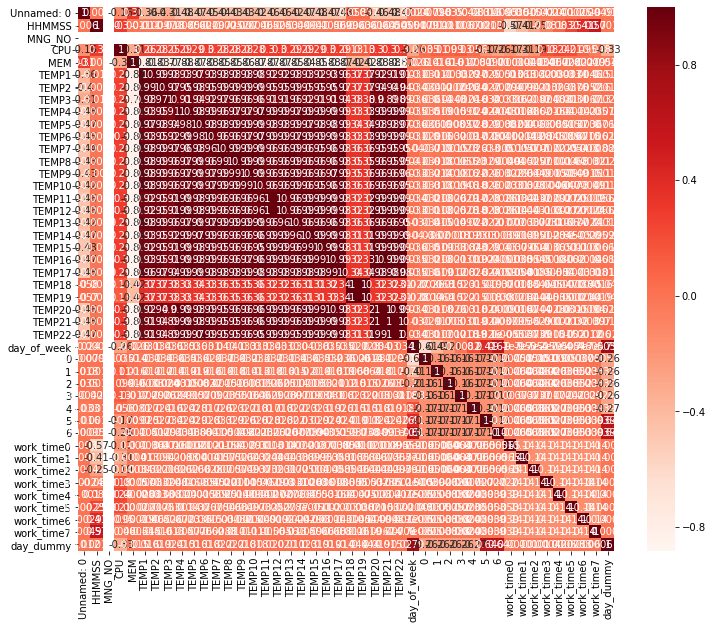

In [393]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = origin_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [401]:
#Correlation with output variable
cor_target = abs(cor["CPU"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.28]
relevant_features

HHMMSS        0.299504
CPU           1.000000
MEM           0.311312
TEMP4         0.294232
TEMP5         0.289220
TEMP6         0.299946
TEMP9         0.280894
TEMP10        0.284740
TEMP11        0.295896
TEMP12        0.295884
TEMP13        0.286555
TEMP14        0.286529
TEMP15        0.288817
TEMP16        0.297481
TEMP17        0.289847
TEMP20        0.295365
TEMP21        0.299432
TEMP22        0.296695
work_time1    0.312771
day_dummy     0.330316
Name: CPU, dtype: float64

In [415]:
list(relevant_features.reset_index().loc[:,'index'].values)

['HHMMSS',
 'CPU',
 'MEM',
 'TEMP4',
 'TEMP5',
 'TEMP6',
 'TEMP9',
 'TEMP10',
 'TEMP11',
 'TEMP12',
 'TEMP13',
 'TEMP14',
 'TEMP15',
 'TEMP16',
 'TEMP17',
 'TEMP20',
 'TEMP21',
 'TEMP22',
 'work_time1',
 'day_dummy']

# Feature to sequential Data

In [686]:
seq_len = 6
second_seq_len = 12

In [687]:
def sequence_data(data, seq_len):
    x = data.values
    y = data.values[:,-1]
    
#     scaler.fit(x)
#     x = scaler.transform(x)
    
    dataX = []
    dataY = []
    
    for i in range(0, len(y)-30):
        _x = x[30-seq_len+i : 30+i]
        _y = y[30+i]
        
        dataX.append(_x)
        dataY.append(_y)
    
    #split t rain, valid, test
    x_train, x_valid, y_train, y_valid = train_test_split(dataX, dataY, test_size=0.3, shuffle=False)
    x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, shuffle=False)
    
    x_train = np.array(x_train)
    x_valid = np.array(x_valid)
    x_test = np.array(x_test)

    y_train = np.array(y_train)
    y_valid = np.array(y_valid)
    y_test = np.array(y_test)
    
    
    return [x_train, x_valid, x_test, y_train, y_valid, y_test, np.array(dataX), np.array(dataY)]

In [688]:
x_train, x_valid, x_test, y_train, y_valid, y_test, dataX, dataY = sequence_data(all_df, seq_len)

In [689]:
x_train_30, x_valid_30, x_test_30, y_train_30, y_valid_30, y_test_30, dataX_30, dataY_30 = sequence_data(all_df, second_seq_len)

# Shuffling

In [690]:
np.random.seed(401)
shuffle_index = np.random.choice(len(dataX), len(dataX), replace=False)
shuffle_index

train_index = shuffle_index[0:int(len(dataX)*0.7)]
valid_index = shuffle_index[int(len(dataX)*0.7):int(len(dataX)*0.7)+int(len(dataX)*0.15)]
test_index = shuffle_index[int(len(dataX)*0.7)+int(len(dataX)*0.15):]

x_train = dataX[train_index]
y_train = dataY[train_index]
x_valid = dataX[valid_index]
y_valid = dataY[valid_index]
x_test = dataX[test_index]
y_test = dataY[test_index]

x_train_30 = dataX_30[train_index]
# y_train_30 = dataY_30[train_index]
x_valid_30 = dataX_30[valid_index]
# y_valid_30 = dataY_30[valid_index]
x_test_30 = dataX_30[test_index]
# y_test_30 = dataY_30[test_index]

# shift Sequential

In [691]:
shift_num = 12

In [692]:
x_train_ = x_train[shift_num:]
x_train_shift = x_train[:-shift_num]

x_valid_ = x_valid[shift_num:]
x_valid_shift = x_valid[:-shift_num]

x_test_ = x_test[shift_num:]
x_test_shift = x_test[:-shift_num]

y_train_ = y_train[shift_num:]
y_valid_ = y_valid[shift_num:]
y_test_ = y_test[shift_num:]

In [693]:
print('train', x_train.shape)
print('valid', x_valid.shape)
print('test', x_test.shape)
print('')
print('train_30', x_train_30.shape)
print('valid_30', x_valid_30.shape)
print('test_30', x_test_30.shape)
print('')
print('train_shift', x_train_shift.shape)
print('valid_shift', x_valid_shift.shape)
print('test_shift', x_test_shift.shape)
print('')
print('train_', x_train_.shape)
print('valid_', x_valid_.shape)
print('test_', x_test_.shape)


train (30293, 6, 16)
valid (6491, 6, 16)
test (6493, 6, 16)

train_30 (30293, 12, 16)
valid_30 (6491, 12, 16)
test_30 (6493, 12, 16)

train_shift (30281, 6, 16)
valid_shift (6479, 6, 16)
test_shift (6481, 6, 16)

train_ (30281, 6, 16)
valid_ (6479, 6, 16)
test_ (6481, 6, 16)


# Anomaly traffic forecasting Model

In [573]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.sigmoid(a_it)
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [656]:
def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)

    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)
    
    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)
#     aggregated_representation = Lambda(lambda x: K.max(x, axis=1))(aggregated_representation)
#     aggregated_representation = Lambda(lambda x: K.dot(K.transpose(attentions), representations))

    
    return aggregated_representation

In [300]:
def get_huber_loss_fn(**huber_loss_kwargs):
    def custom_huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true, y_pred, **huber_loss_kwargs)
    return custom_huber_loss

In [301]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [302]:
leaky_relu = tf.nn.leaky_relu

In [643]:
feature_size = x_train.shape[2]
lstm_size = 256
learning_rate=0.0001
dense_node = 128
attention_dim = 100

In [672]:
def get_model():
#     K.clear_session()
    np.random.seed(100)
    
    inp = Input(shape=(seq_len, feature_size), name='input')
    lstm = CuDNNLSTM(lstm_size, return_sequences=True)(inp)
#     layer = Dense(lstm_size, activation='relu')(lstm)
    attention = AttentionLayer(attention_dim)(lstm)
    representation = WeightedSum(attention, lstm)
#     layer = Dense(int(dense_node*2), activation='relu')(representation)
#     maxpooling = Lambda(lambda x: K.max(x, axis=1))(layer)  
    fc = Dense(dense_node, activation='relu')(representation)
#     batch_norm = BatchNormalization()(layer)
#     dropout = Dropout(0.5)(batch_norm)
    output_predict = Dense(1)(fc)
    predict_model = Model(inputs=inp, outputs=output_predict)
    
    
    predict_model.compile(loss=lambda y,f: tilted_loss(0.9,y,f),
                  optimizer=Adam(learning_rate),
                  metrics=[r_square])

    return predict_model

In [625]:
def get_model():
    cpu_model = Sequential()
    cpu_model.add(CuDNNLSTM(256, input_shape=(None, feature_size)))
    #model.add(Dropout(0.5))
    cpu_model.add(Dense(1))
    cpu_model.compile(
#                       loss='mae',
#                       loss=get_huber_loss_fn(delta=5.0),
                      loss=lambda y,f: tilted_loss(0.8,y,f),
                      optimizer='adam', 
                      metrics=[r_square])
    adam_optimizer = Adam(learning_rate)

    # MODEL_SAVE_FOLDER_PATH = save_path2
    # if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    #   os.mkdir(MODEL_SAVE_FOLDER_PATH)

    # model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
    # cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    return cpu_model

In [674]:
# model, extract_model = get_model()
model = get_model()
model.summary()
checkpoint = ModelCheckpoint('./218_cpu.hdf5', save_best_only=True, verbose=2, monitor='val_loss')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 12, 16)       0                                            
__________________________________________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)        (None, 12, 256)      280576      input[0][0]                      
__________________________________________________________________________________________________
attention_layer_4 (AttentionLay (None, 12)           25800       cu_dnnlstm_4[0][0]               
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 256, 12)      0           attention_layer_4[0][0]          
____________________________________________________________________________________________

In [676]:
hist = model.fit(x_train, y_train, 
                 callbacks=[checkpoint],
                 validation_data=(x_valid, y_valid), 
                 batch_size=64, 
                 epochs=500,
                 shuffle=False,
                 verbose=2)

Train on 30293 samples, validate on 6491 samples
Epoch 1/500
 - 3s - loss: 0.0444 - r_square: 0.5018 - val_loss: 0.0457 - val_r_square: 0.5314

Epoch 00001: val_loss did not improve from 0.04338
Epoch 2/500
 - 3s - loss: 0.0448 - r_square: 0.4994 - val_loss: 0.0446 - val_r_square: 0.5137

Epoch 00002: val_loss did not improve from 0.04338
Epoch 3/500
 - 3s - loss: 0.0446 - r_square: 0.5015 - val_loss: 0.0445 - val_r_square: 0.5343

Epoch 00003: val_loss did not improve from 0.04338
Epoch 4/500
 - 3s - loss: 0.0444 - r_square: 0.5032 - val_loss: 0.0446 - val_r_square: 0.5526

Epoch 00004: val_loss did not improve from 0.04338
Epoch 5/500
 - 3s - loss: 0.0442 - r_square: 0.5023 - val_loss: 0.0445 - val_r_square: 0.5316

Epoch 00005: val_loss did not improve from 0.04338
Epoch 6/500
 - 3s - loss: 0.0444 - r_square: 0.5025 - val_loss: 0.0443 - val_r_square: 0.4992

Epoch 00006: val_loss did not improve from 0.04338
Epoch 7/500
 - 3s - loss: 0.0444 - r_square: 0.5018 - val_loss: 0.0434 - va

Epoch 00109: val_loss did not improve from 0.03883
Epoch 110/500
 - 3s - loss: 0.0394 - r_square: 0.5364 - val_loss: 0.0404 - val_r_square: 0.5768

Epoch 00110: val_loss did not improve from 0.03883
Epoch 111/500
 - 3s - loss: 0.0394 - r_square: 0.5353 - val_loss: 0.0390 - val_r_square: 0.5827

Epoch 00111: val_loss did not improve from 0.03883
Epoch 112/500
 - 3s - loss: 0.0393 - r_square: 0.5378 - val_loss: 0.0389 - val_r_square: 0.5933

Epoch 00112: val_loss did not improve from 0.03883
Epoch 113/500
 - 3s - loss: 0.0394 - r_square: 0.5366 - val_loss: 0.0423 - val_r_square: 0.5476

Epoch 00113: val_loss did not improve from 0.03883
Epoch 114/500
 - 3s - loss: 0.0392 - r_square: 0.5373 - val_loss: 0.0402 - val_r_square: 0.5836

Epoch 00114: val_loss did not improve from 0.03883
Epoch 115/500
 - 3s - loss: 0.0392 - r_square: 0.5362 - val_loss: 0.0405 - val_r_square: 0.5759

Epoch 00115: val_loss did not improve from 0.03883
Epoch 116/500
 - 3s - loss: 0.0389 - r_square: 0.5396 - val_l


Epoch 00219: val_loss did not improve from 0.03697
Epoch 220/500
 - 3s - loss: 0.0371 - r_square: 0.5505 - val_loss: 0.0386 - val_r_square: 0.5729

Epoch 00220: val_loss did not improve from 0.03697
Epoch 221/500
 - 3s - loss: 0.0371 - r_square: 0.5491 - val_loss: 0.0397 - val_r_square: 0.5406

Epoch 00221: val_loss did not improve from 0.03697
Epoch 222/500
 - 3s - loss: 0.0370 - r_square: 0.5514 - val_loss: 0.0377 - val_r_square: 0.5782

Epoch 00222: val_loss did not improve from 0.03697
Epoch 223/500
 - 3s - loss: 0.0372 - r_square: 0.5510 - val_loss: 0.0374 - val_r_square: 0.5746

Epoch 00223: val_loss did not improve from 0.03697
Epoch 224/500
 - 3s - loss: 0.0369 - r_square: 0.5502 - val_loss: 0.0382 - val_r_square: 0.5755

Epoch 00224: val_loss did not improve from 0.03697
Epoch 225/500
 - 3s - loss: 0.0368 - r_square: 0.5525 - val_loss: 0.0379 - val_r_square: 0.5767

Epoch 00225: val_loss did not improve from 0.03697
Epoch 226/500
 - 3s - loss: 0.0368 - r_square: 0.5508 - val_


Epoch 00330: val_loss did not improve from 0.03697
Epoch 331/500
 - 3s - loss: 0.0352 - r_square: 0.5689 - val_loss: 0.0374 - val_r_square: 0.5655

Epoch 00331: val_loss did not improve from 0.03697
Epoch 332/500
 - 3s - loss: 0.0352 - r_square: 0.5671 - val_loss: 0.0389 - val_r_square: 0.5553

Epoch 00332: val_loss did not improve from 0.03697
Epoch 333/500
 - 3s - loss: 0.0353 - r_square: 0.5684 - val_loss: 0.0381 - val_r_square: 0.5687

Epoch 00333: val_loss did not improve from 0.03697
Epoch 334/500
 - 3s - loss: 0.0353 - r_square: 0.5668 - val_loss: 0.0383 - val_r_square: 0.5612

Epoch 00334: val_loss did not improve from 0.03697
Epoch 335/500
 - 3s - loss: 0.0354 - r_square: 0.5670 - val_loss: 0.0379 - val_r_square: 0.5752

Epoch 00335: val_loss did not improve from 0.03697
Epoch 336/500
 - 3s - loss: 0.0355 - r_square: 0.5656 - val_loss: 0.0385 - val_r_square: 0.5876

Epoch 00336: val_loss did not improve from 0.03697
Epoch 337/500
 - 3s - loss: 0.0352 - r_square: 0.5708 - val_


Epoch 00385: val_loss did not improve from 0.03694
Epoch 386/500
 - 3s - loss: 0.0345 - r_square: 0.5753 - val_loss: 0.0371 - val_r_square: 0.5761

Epoch 00386: val_loss did not improve from 0.03694
Epoch 387/500
 - 3s - loss: 0.0348 - r_square: 0.5681 - val_loss: 0.0376 - val_r_square: 0.5857

Epoch 00387: val_loss did not improve from 0.03694
Epoch 388/500
 - 3s - loss: 0.0350 - r_square: 0.5722 - val_loss: 0.0377 - val_r_square: 0.5805

Epoch 00388: val_loss did not improve from 0.03694
Epoch 389/500
 - 3s - loss: 0.0352 - r_square: 0.5658 - val_loss: 0.0382 - val_r_square: 0.5496

Epoch 00389: val_loss did not improve from 0.03694
Epoch 390/500
 - 3s - loss: 0.0346 - r_square: 0.5719 - val_loss: 0.0378 - val_r_square: 0.5775

Epoch 00390: val_loss did not improve from 0.03694
Epoch 391/500
 - 3s - loss: 0.0347 - r_square: 0.5708 - val_loss: 0.0395 - val_r_square: 0.5977

Epoch 00391: val_loss did not improve from 0.03694
Epoch 392/500
 - 3s - loss: 0.0345 - r_square: 0.5768 - val_

Epoch 496/500
 - 3s - loss: 0.0328 - r_square: 0.5895 - val_loss: 0.0400 - val_r_square: 0.5553

Epoch 00496: val_loss did not improve from 0.03664
Epoch 497/500
 - 3s - loss: 0.0329 - r_square: 0.5911 - val_loss: 0.0373 - val_r_square: 0.5725

Epoch 00497: val_loss did not improve from 0.03664
Epoch 498/500
 - 3s - loss: 0.0330 - r_square: 0.5844 - val_loss: 0.0388 - val_r_square: 0.5846

Epoch 00498: val_loss did not improve from 0.03664
Epoch 499/500
 - 3s - loss: 0.0330 - r_square: 0.5893 - val_loss: 0.0380 - val_r_square: 0.5772

Epoch 00499: val_loss did not improve from 0.03664
Epoch 500/500
 - 3s - loss: 0.0328 - r_square: 0.5903 - val_loss: 0.0379 - val_r_square: 0.5832

Epoch 00500: val_loss did not improve from 0.03664


In [661]:
hist = model.fit([x_train_,x_train_shift], y_train_, 
                 callbacks=[checkpoint],
                 validation_data=([x_valid_,x_valid_shift], y_valid_), 
                 batch_size=64, 
                 epochs=500,
                 verbose=2)

Train on 30281 samples, validate on 6479 samples
Epoch 1/500
 - 6s - loss: 7.1132 - r_square: -1.6252e+02 - val_loss: 1.5437 - val_r_square: -1.2440e+02

Epoch 00001: val_loss improved from inf to 1.54369, saving model to ./218_cpu.hdf5
Epoch 2/500
 - 5s - loss: 5.5730 - r_square: -1.0734e+02 - val_loss: 5.6710 - val_r_square: -1.0533e+02

Epoch 00002: val_loss did not improve from 1.54369
Epoch 3/500
 - 5s - loss: 3.0462 - r_square: -3.4138e+01 - val_loss: 0.6990 - val_r_square: -2.5259e+01

Epoch 00003: val_loss improved from 1.54369 to 0.69903, saving model to ./218_cpu.hdf5
Epoch 4/500
 - 5s - loss: 0.4017 - r_square: -5.2472e-01 - val_loss: 0.3452 - val_r_square: -5.2546e+00

Epoch 00004: val_loss improved from 0.69903 to 0.34516, saving model to ./218_cpu.hdf5
Epoch 5/500
 - 5s - loss: 0.1016 - r_square: 0.5772 - val_loss: 0.5861 - val_r_square: -3.5143e-01

Epoch 00005: val_loss did not improve from 0.34516
Epoch 6/500
 - 5s - loss: 0.0976 - r_square: 0.6046 - val_loss: 0.2473 -


Epoch 00053: val_loss did not improve from 0.07680
Epoch 54/500
 - 5s - loss: 0.0829 - r_square: 0.6518 - val_loss: 0.2762 - val_r_square: 0.5790

Epoch 00054: val_loss did not improve from 0.07680
Epoch 55/500
 - 5s - loss: 0.0825 - r_square: 0.6548 - val_loss: 0.1588 - val_r_square: 0.7341

Epoch 00055: val_loss did not improve from 0.07680
Epoch 56/500
 - 5s - loss: 0.0820 - r_square: 0.6474 - val_loss: 0.6253 - val_r_square: -4.6098e-01

Epoch 00056: val_loss did not improve from 0.07680
Epoch 57/500
 - 5s - loss: 0.0815 - r_square: 0.6549 - val_loss: 0.1638 - val_r_square: -5.3770e-01

Epoch 00057: val_loss did not improve from 0.07680
Epoch 58/500
 - 5s - loss: 0.0809 - r_square: 0.6537 - val_loss: 0.0912 - val_r_square: 0.5201

Epoch 00058: val_loss did not improve from 0.07680
Epoch 59/500
 - 5s - loss: 0.0816 - r_square: 0.6478 - val_loss: 0.2419 - val_r_square: 0.6611

Epoch 00059: val_loss did not improve from 0.07680
Epoch 60/500
 - 5s - loss: 0.0819 - r_square: 0.6457 - v

Epoch 162/500
 - 5s - loss: 0.0709 - r_square: 0.6341 - val_loss: 0.0568 - val_r_square: 0.7051

Epoch 00162: val_loss did not improve from 0.05558
Epoch 163/500
 - 5s - loss: 0.0696 - r_square: 0.6359 - val_loss: 0.0640 - val_r_square: 0.6531

Epoch 00163: val_loss did not improve from 0.05558
Epoch 164/500
 - 5s - loss: 0.0695 - r_square: 0.6405 - val_loss: 0.0593 - val_r_square: 0.6732

Epoch 00164: val_loss did not improve from 0.05558
Epoch 165/500
 - 5s - loss: 0.0693 - r_square: 0.6355 - val_loss: 0.0678 - val_r_square: 0.7278

Epoch 00165: val_loss did not improve from 0.05558
Epoch 166/500
 - 5s - loss: 0.0699 - r_square: 0.6342 - val_loss: 0.0663 - val_r_square: 0.6257

Epoch 00166: val_loss did not improve from 0.05558
Epoch 167/500
 - 5s - loss: 0.0697 - r_square: 0.6392 - val_loss: 0.0593 - val_r_square: 0.6824

Epoch 00167: val_loss did not improve from 0.05558
Epoch 168/500
 - 5s - loss: 0.0713 - r_square: 0.6290 - val_loss: 0.0567 - val_r_square: 0.7040

Epoch 00168: va

Epoch 00271: val_loss did not improve from 0.05348
Epoch 272/500
 - 4s - loss: 0.0687 - r_square: 0.6487 - val_loss: 0.0629 - val_r_square: 0.6740

Epoch 00272: val_loss did not improve from 0.05348
Epoch 273/500
 - 4s - loss: 0.0685 - r_square: 0.6533 - val_loss: 0.0671 - val_r_square: 0.7310

Epoch 00273: val_loss did not improve from 0.05348
Epoch 274/500
 - 4s - loss: 0.0674 - r_square: 0.6530 - val_loss: 0.0790 - val_r_square: 0.7353

Epoch 00274: val_loss did not improve from 0.05348
Epoch 275/500
 - 4s - loss: 0.0673 - r_square: 0.6551 - val_loss: 0.0541 - val_r_square: 0.6995

Epoch 00275: val_loss did not improve from 0.05348
Epoch 276/500
 - 4s - loss: 0.0684 - r_square: 0.6513 - val_loss: 0.0598 - val_r_square: 0.7210

Epoch 00276: val_loss did not improve from 0.05348
Epoch 277/500
 - 4s - loss: 0.0686 - r_square: 0.6469 - val_loss: 0.0547 - val_r_square: 0.6847

Epoch 00277: val_loss did not improve from 0.05348
Epoch 278/500
 - 4s - loss: 0.0677 - r_square: 0.6515 - val_l


Epoch 00381: val_loss did not improve from 0.05140
Epoch 382/500
 - 4s - loss: 0.0660 - r_square: 0.6603 - val_loss: 0.0588 - val_r_square: 0.6633

Epoch 00382: val_loss did not improve from 0.05140
Epoch 383/500
 - 4s - loss: 0.0679 - r_square: 0.6579 - val_loss: 0.0590 - val_r_square: 0.6966

Epoch 00383: val_loss did not improve from 0.05140
Epoch 384/500
 - 4s - loss: 0.0667 - r_square: 0.6577 - val_loss: 0.0593 - val_r_square: 0.6661

Epoch 00384: val_loss did not improve from 0.05140
Epoch 385/500
 - 4s - loss: 0.0659 - r_square: 0.6654 - val_loss: 0.0550 - val_r_square: 0.7007

Epoch 00385: val_loss did not improve from 0.05140
Epoch 386/500
 - 4s - loss: 0.0667 - r_square: 0.6595 - val_loss: 0.0763 - val_r_square: 0.7415

Epoch 00386: val_loss did not improve from 0.05140
Epoch 387/500
 - 4s - loss: 0.0662 - r_square: 0.6676 - val_loss: 0.0556 - val_r_square: 0.6824

Epoch 00387: val_loss did not improve from 0.05140
Epoch 388/500
 - 5s - loss: 0.0670 - r_square: 0.6588 - val_


Epoch 00492: val_loss did not improve from 0.05140
Epoch 493/500
 - 4s - loss: 0.0656 - r_square: 0.6659 - val_loss: 0.0641 - val_r_square: 0.6347

Epoch 00493: val_loss did not improve from 0.05140
Epoch 494/500
 - 4s - loss: 0.0641 - r_square: 0.6717 - val_loss: 0.0554 - val_r_square: 0.6961

Epoch 00494: val_loss did not improve from 0.05140
Epoch 495/500
 - 4s - loss: 0.0655 - r_square: 0.6678 - val_loss: 0.0545 - val_r_square: 0.6949

Epoch 00495: val_loss did not improve from 0.05140
Epoch 496/500
 - 4s - loss: 0.0646 - r_square: 0.6693 - val_loss: 0.0563 - val_r_square: 0.7138

Epoch 00496: val_loss did not improve from 0.05140
Epoch 497/500
 - 4s - loss: 0.0651 - r_square: 0.6680 - val_loss: 0.0543 - val_r_square: 0.6904

Epoch 00497: val_loss did not improve from 0.05140
Epoch 498/500
 - 4s - loss: 0.0663 - r_square: 0.6647 - val_loss: 0.0558 - val_r_square: 0.6821

Epoch 00498: val_loss did not improve from 0.05140
Epoch 499/500
 - 4s - loss: 0.0662 - r_square: 0.6647 - val_

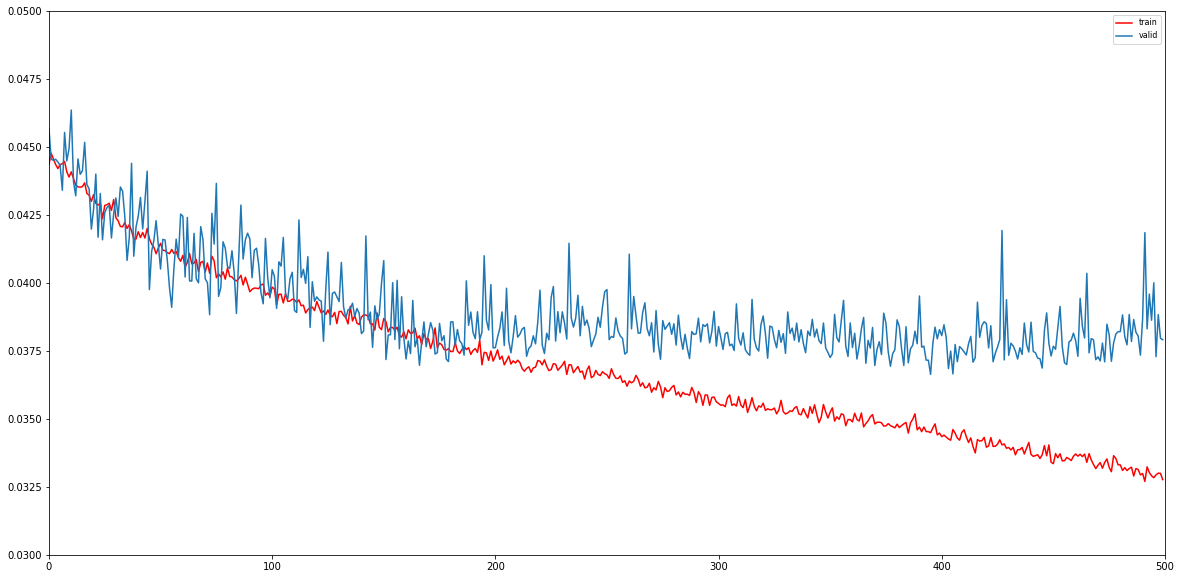

In [699]:
plt.plot(hist.history["loss"], color='red')
plt.plot(hist.history["val_loss"])
plt.legend(['train', 'valid'], fontsize = 8)
plt.xlim(0,500)
plt.ylim(0.03,0.05)
plt.show()

In [628]:
model.load_weights('./218_cpu.hdf5')

# Evaluation

In [678]:
pred_trn = model.predict(x_train)
print('trn')
evaluate(y_train, pred_trn)

pred_val = model.predict(x_valid)
print('val')
evaluate(y_valid, pred_val)

pred_te = model.predict(x_test)
print('test')
evaluate(y_test, pred_te)

# pred_trn = model.predict([x_train, x_train_30])
# print('trn')
# evaluate(y_train, pred_trn)

# pred_val = model.predict([x_valid, x_valid_30])
# print('val')
# evaluate(y_valid, pred_val)

# pred_te = model.predict([x_test, x_test_30])
# print('test')
# evaluate(y_test, pred_te)

# pred_trn = model.predict([x_train_, x_train_shift])
# print('trn')
# evaluate(y_train_, pred_trn)

# pred_val = model.predict([x_valid_, x_valid_shift])
# print('val')
# evaluate(y_valid_, pred_val)

# pred_te = model.predict([x_test_, x_test_shift])
# print('test')
# evaluate(y_test_, pred_te)

trn
mae: 0.2227
rmse: 0.4504
me: -0.1945
fvu: 0.3926
val
mae: 0.2263
rmse: 0.4559
me: -0.1880
fvu: 0.4037
test
mae: 0.2325
rmse: 0.4611
me: -0.1948
fvu: 0.4119


# Attention Visualization

In [486]:
#attention extractor
extract_trn = extract_model.predict([x_train_, x_train_shift])
print('trn')

extract_val = extract_model.predict([x_valid_, x_valid_shift])
print('val')

extract_te = extract_model.predict([x_test_, x_test_shift])
print('test')

trn
val
test


In [466]:
over_idx = [idx for idx, i in enumerate(y_train_) if i>=12]

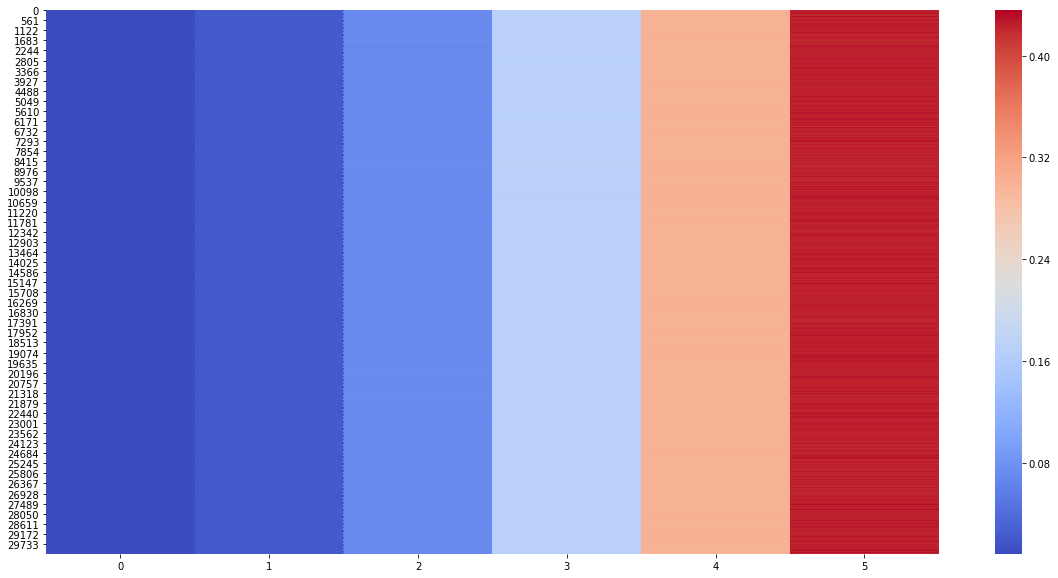

In [697]:
sns.heatmap(extract_trn[2],cmap='coolwarm')

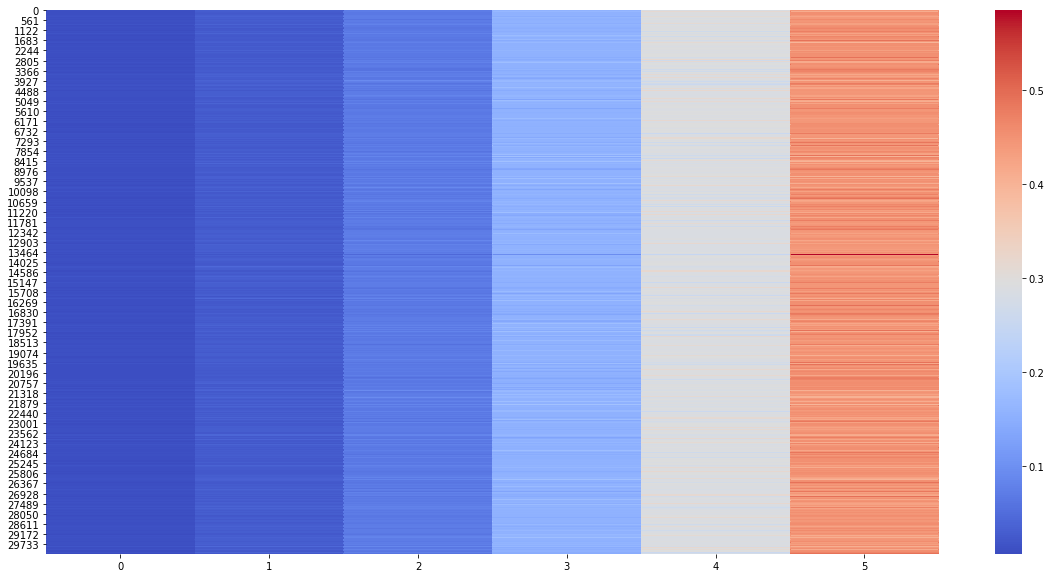

In [696]:
sns.heatmap(extract_trn[0],cmap='coolwarm')

TRAIN!!!


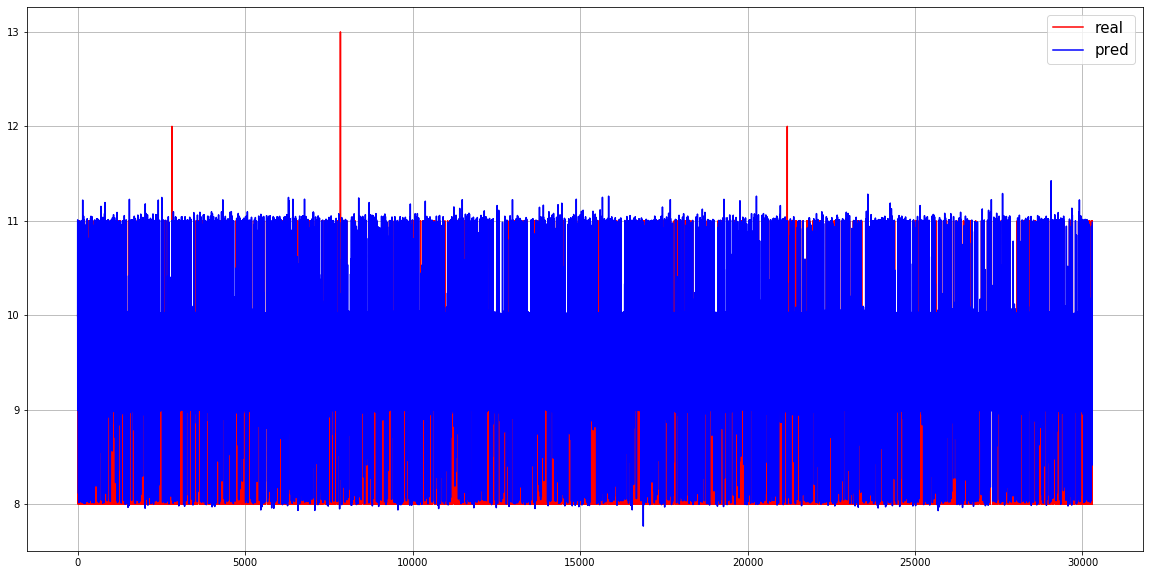

In [679]:
print('TRAIN!!!')

plt.plot(y_train, color='red')
plt.plot(pred_trn, color='blue')
plt.legend(['real', 'pred'], fontsize = 15)
plt.grid()
plt.show()

VALID!!!


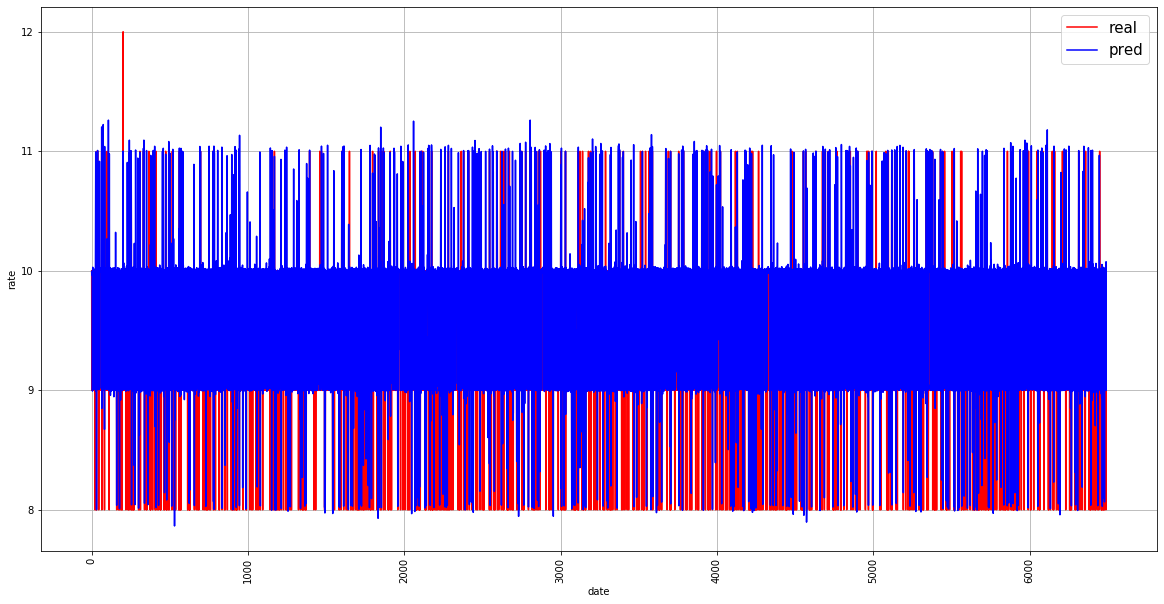

In [680]:
print('VALID!!!')

plt.plot(y_valid, color='red')
plt.plot(pred_val, color='blue')
plt.legend(['real', 'pred'], fontsize = 15)
plt.grid()
plt.xlabel('date')
plt.ylabel('rate')
plt.xticks(rotation='vertical')
plt.show()

TEST!!!


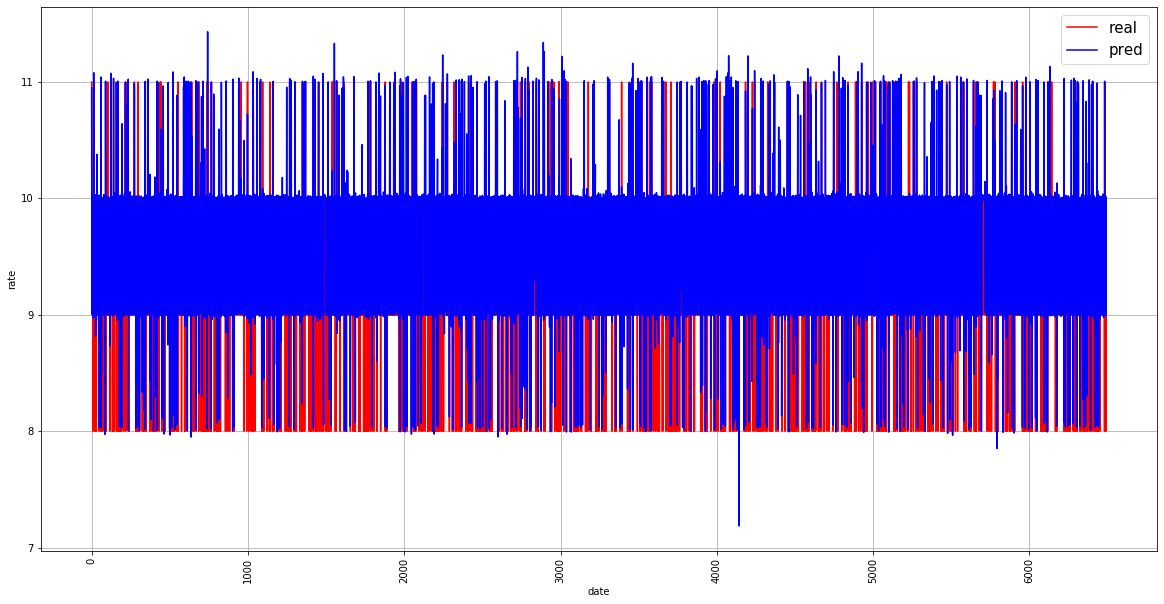

In [681]:
print('TEST!!!')

plt.plot(y_test, color='red')
plt.plot(pred_te, color='blue')
plt.legend(['real', 'pred'], fontsize = 15)
plt.grid()
plt.xlabel('date')
plt.ylabel('rate')
plt.xticks(rotation='vertical')
plt.show()

In [682]:
threshold = 11

anomaly_y_trn = [0 if i>=threshold else 1 for i in y_train]
anomaly_pred_trn = [0 if i>=threshold else 1 for i in pred_trn]

anomaly_y_val = [0 if i>=threshold else 1 for i in y_valid]
anomaly_pred_val = [0 if i>=threshold else 1 for i in pred_val]

anomaly_y_te = [0 if i>=threshold else 1 for i in y_test]
anomaly_pred_te = [0 if i>=threshold else 1 for i in pred_te]

# anomaly_y_trn = [0 if i>=threshold else 1 for i in y_train_]
# anomaly_pred_trn = [0 if i>=threshold else 1 for i in pred_trn]

# anomaly_y_val = [0 if i>=threshold else 1 for i in y_valid_]
# anomaly_pred_val = [0 if i>=threshold else 1 for i in pred_val]

# anomaly_y_te = [0 if i>=threshold else 1 for i in y_test_]
# anomaly_pred_te = [0 if i>=threshold else 1 for i in pred_te]

In [683]:
print('train')
print(classification_report(anomaly_y_trn, anomaly_pred_trn, digits=2))
print('confusion matrix')
print(confusion_matrix(anomaly_y_trn, anomaly_pred_trn))

train
              precision    recall  f1-score   support

           0       0.57      0.56      0.56       902
           1       0.99      0.99      0.99     29391

    accuracy                           0.97     30293
   macro avg       0.78      0.77      0.78     30293
weighted avg       0.97      0.97      0.97     30293

confusion matrix
[[  502   400]
 [  375 29016]]


In [684]:
print('valid')
print(classification_report(anomaly_y_val, anomaly_pred_val, digits=5))
print('confusion matrix')
print(confusion_matrix(anomaly_y_val, anomaly_pred_val))

valid
              precision    recall  f1-score   support

           0    0.55056   0.51309   0.53117       191
           1    0.98527   0.98730   0.98628      6300

    accuracy                        0.97335      6491
   macro avg    0.76792   0.75020   0.75872      6491
weighted avg    0.97248   0.97335   0.97289      6491

confusion matrix
[[  98   93]
 [  80 6220]]


In [685]:
print('test')
print(classification_report(anomaly_y_te, anomaly_pred_te, digits=5))
print('confusion matrix')
print(confusion_matrix(anomaly_y_te, anomaly_pred_te))

test
              precision    recall  f1-score   support

           0    0.56250   0.49749   0.52800       199
           1    0.98417   0.98777   0.98596      6294

    accuracy                        0.97274      6493
   macro avg    0.77333   0.74263   0.75698      6493
weighted avg    0.97125   0.97274   0.97193      6493

confusion matrix
[[  99  100]
 [  77 6217]]
